# 2. Load Data, Summary

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
plt.style.use('ggplot')

In [16]:
path = "train_small_new.csv"
train = pd.read_csv(path)
train.head()

,date,country,province,confirmed
0,1/16/2020,5,1,13
1,1/18/2020,14,1,11
2,1/12/2020,10,1,14
3,1/12/2020,12,1,13
4,2/29/2020,8,1,10


In [8]:
train.shape

(1199, 4)

In [9]:
train["year"] = pd.to_datetime(train["date"]).dt.year
train["month"] = pd.to_datetime(train["date"]).dt.month
train["month_year"] = pd.to_datetime(train["date"]).dt.to_period('M')
train.head()

,date,country,province,confirmed,year,month,month_year
0,1/16/2020,5,1,13,2020,1,2020-01
1,1/18/2020,14,1,11,2020,1,2020-01
2,1/12/2020,10,1,14,2020,1,2020-01
3,1/12/2020,12,1,13,2020,1,2020-01
4,2/29/2020,8,1,10,2020,2,2020-02


# 3. Missing Values

In [10]:
# train.count() will give a value only if not nan
count_nan = len(train) - train.count()
count_nan

date          0
country       0
province      0
confirmed     0
year          0
month         0
month_year    0
dtype: int64

# 4. Individual Feature Visualization

# 4.1 Histogram of daily covid-19 cases

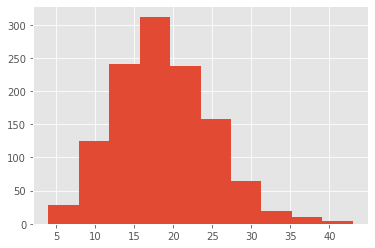

In [11]:
plt.hist(train["confirmed"])
plt.show()

 # 4.2 Increase in number of cases by date and change of increase in cases

In [12]:
mean_confirmed = train.groupby(["date"], as_index=False)
mean_confirmed = mean_confirmed[["confirmed"]].mean()
mean_confirmed["idx"] = mean_confirmed.index

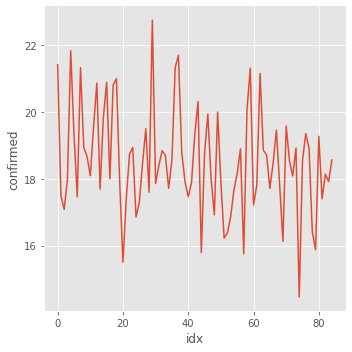

In [13]:
g = sns.relplot(x="idx", y="confirmed", data=mean_confirmed, kind="line")

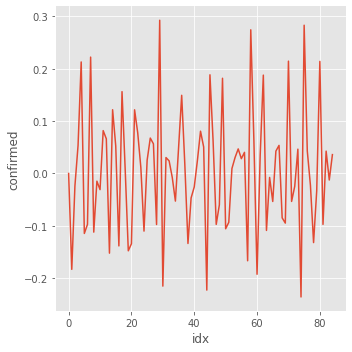

In [14]:
#Change in rate of cases
rt = pd.Series(mean_confirmed["confirmed"]).pct_change()
rt = pd.DataFrame(rt)
rt["idx"] = rt.index
rt.fillna(0, inplace=True)
g = sns.relplot(y="confirmed", x="idx", data=rt, kind="line")

# 4.3 Increase in cases monthly

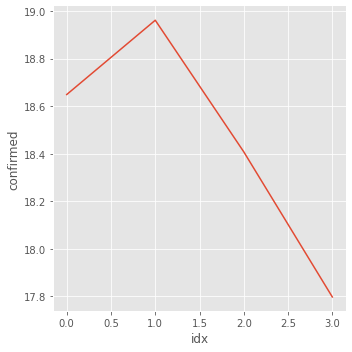

In [122]:
mean_confirmed_monthly = train.groupby(["month_year"], as_index=False)
mean_confirmed_monthly = mean_confirmed_monthly[["confirmed"]].mean()
mean_confirmed_monthly["idx"] = mean_confirmed_monthly.index
g = sns.relplot(y="confirmed", x="idx", data=mean_confirmed_monthly, kind="line")

# 4.4 Increase in Cases by country

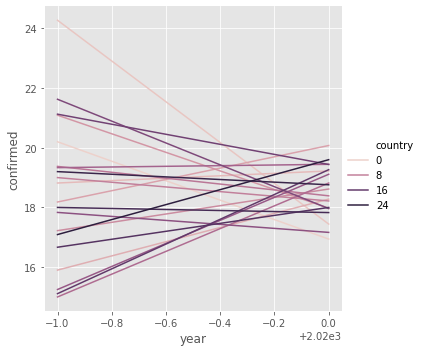

In [123]:
data = train.groupby(['country',"year"])
mean = data[["confirmed"]].mean()
mean = mean.add_suffix('').reset_index()
g = sns.relplot(y="confirmed", x="year", data=mean, kind="line", hue="country")


# 5. Prophet Model

# Building the model for country=5(USA)

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
s1i1 = train[(train["country"]==5)]
s1i1["confirmed"] = np.log1p(s1i1["confirmed"])
s1i1.head()

,date,country,province,confirmed
0,1/16/2020,5,1,2.639057
5,12/26/2019,5,1,2.564949
28,3/6/2020,5,1,1.945910
38,3/12/2020,5,1,2.484907
66,2/8/2020,5,1,2.772589


In [19]:
stats = s1i1[["date", "confirmed"]]
stats.columns = ["ds", "y"]
stats.head()

,ds,y
0,1/16/2020,2.639057
5,12/26/2019,2.564949
28,3/6/2020,1.945910
38,3/12/2020,2.484907
66,2/8/2020,2.772589


In [25]:
m = Prophet()
m.fit(stats)
future = m.make_future_dataframe(periods=365)
future.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
411,2021-03-09
412,2021-03-10
413,2021-03-11
414,2021-03-12
415,2021-03-13


In [26]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
411,2021-03-09,3.427855,2.935180,3.866571
412,2021-03-10,3.307382,2.874955,3.741925
413,2021-03-11,3.305090,2.855455,3.715448
414,2021-03-12,3.348294,2.914106,3.783529
415,2021-03-13,3.057959,2.588645,3.455245


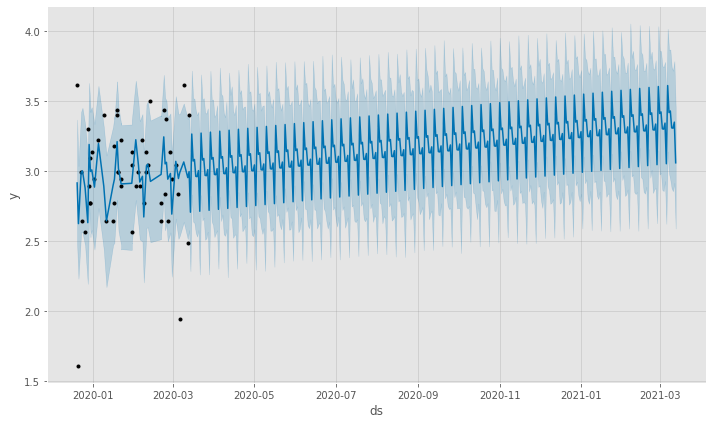

In [27]:
pd.plotting.register_matplotlib_converters()
fig1 = m.plot(forecast)


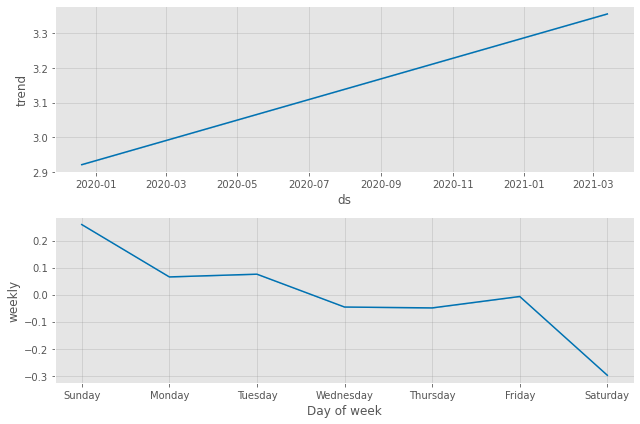

In [28]:
fig2 = m.plot_components(forecast)

SMAPE Calcuation

In [29]:
ps1i1 = forecast[["ds"]]
ps1i1["forecast"] = np.expm1(forecast["yhat"])
ps1i1["yearmonth"] = pd.to_datetime(ps1i1["ds"]).dt.to_period("M")
ps1i1.head()

,ds,forecast,yearmonth
0,2019-12-20,17.432008,2019-12
1,2019-12-21,12.787387,2019-12
2,2019-12-23,18.872492,2019-12
3,2019-12-24,19.094267,2019-12
4,2019-12-26,16.772812,2019-12


In [30]:
def smape(outsample, forecast):
    num = np.abs(outsample-forecast)
    denom = np.abs(outsample) + np.abs(forecast)
    return (num/denom)/2

stats["ds"] = pd.to_datetime(stats["ds"])

In [37]:
ps1i1["ds"] = pd.to_datetime(ps1i1["ds"])

In [32]:
train_predict = stats.merge(ps1i1)

In [33]:
smape_err = smape(train_predict["y"], train_predict["forecast"])
smape_err = smape_err[~np.isnan(smape_err)]
np.mean(smape_err)

0.36151595409219023

# Automated forecasting with Prophet

In [34]:
train["confirmed"] = np.log1p(train["confirmed"]) 
train["confirmed"] = np.log1p(train["confirmed"])
train.columns = ["ds", "country", "item", "confirmed", "y", "m", "my"]
train.head() 

ValueError: Length mismatch: Expected axis has 4 elements, new values have 7 elements

In [35]:
future = m.make_future_dataframe(periods=90)
forecast = m.predict(future)


In [36]:
df = train[(train["country"]==5)]
df = df[["ds", "confirmed"]]
df.columns = ["ds", "y"]
df.head()

KeyError: "['ds'] not in index"